In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import os
import random
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from mste_patch_dataset import *
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter

# Set up the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Show Random Patches

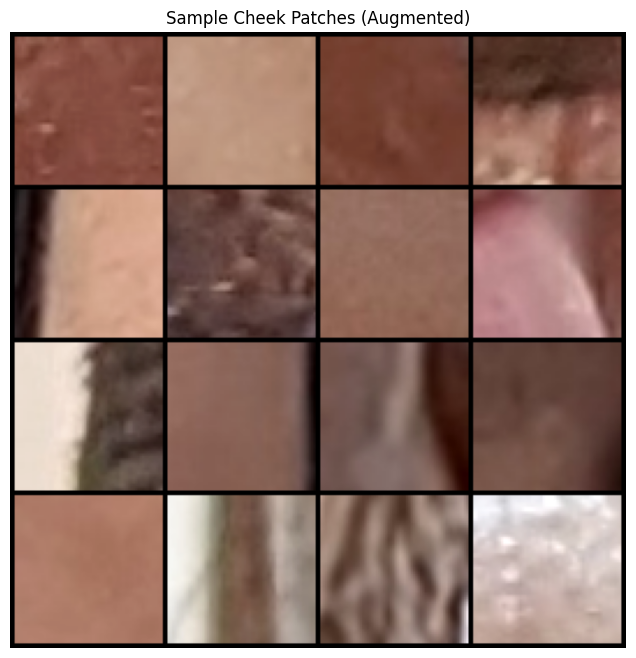

In [3]:
# patches_dir
PATCH_DIR = "/Users/sree/mst-e/cheek_patches_clean"
image_paths = []

# collect all image paths recursively
all_image_paths = []
for root, _, files in os.walk(PATCH_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            all_image_paths.append(os.path.join(root, file))

# randomly sample 16
image_paths = random.sample(all_image_paths, 16)

# load and transform
transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomCrop((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

images = [transform(Image.open(p).convert("RGB")) for p in image_paths]
grid = make_grid(images, nrow=4)

# show the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Sample Cheek Patches (Augmented)")
plt.show()

## Model Definition

In [4]:
class SkinToneVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 3, 64, 64] -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> [B, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [B, 128, 8, 8]
            nn.ReLU(),
            nn.Flatten()  # -> [B, 128*8*8]
        )

        self.flattened_dim = 128 * 8 * 8
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # -> [B, 3, 64, 64]
            nn.Sigmoid()  # outputs in range [0, 1]
        )

        # Regression head to predict LAB + HSL from latent
        self.color_head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 6)  # LAB + HSL output
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(self.fc_decode(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        pred_color = self.color_head(z) # NOTE: uses latent z to predict color rather than mu
        return recon, mu, logvar, pred_color

def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction='mean')
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon + kl
    return total, recon.item(), kl.item()


## Train and Val Data

In [5]:
# Step 1: Load your subject_to_mst mapping
metadata = pd.read_csv("/Users/sree/mst-e/mst-e_image_details.csv")
metadata.columns = metadata.columns.str.strip().str.lower()

subject_to_mst = (
    metadata.drop_duplicates("subject_name")
    .set_index("subject_name")["mst"]
    .dropna()
    .astype(int)
    .to_dict()
)

# Load LAB/HSL embeddings for each MST level
df = pd.read_csv("mst_to_lab_hsl_mapping.csv")
mst_to_vec = {
    int(row["mst_level"]): [row["L"], row["a"], row["b"], row["H"], row["S"], row["L_hsl"]]
    for _, row in df.iterrows()
}

# Step 2: Define special MST handling
special_val_msts = [10]
special_train_msts = [7]

mst_10_subjects = [s for s, m in subject_to_mst.items() if m in special_val_msts]
mst_7_subjects = [s for s, m in subject_to_mst.items() if m in special_train_msts]

# Remaining subjects (not MST 10 or 7)
other_subjects = [
    s for s in subject_to_mst
    if s not in mst_10_subjects + mst_7_subjects
]
other_mst_levels = [subject_to_mst[s] for s in other_subjects]

# Filter out rare MSTs (excluding MST 7)
mst_counts = Counter(other_mst_levels)
rare_msts = {mst for mst, count in mst_counts.items() if count < 2}
filtered_subjects = [s for s in other_subjects if subject_to_mst[s] not in rare_msts]

# Step 3: Perform random (non-stratified) split
train_base, val_base = train_test_split(
    filtered_subjects,
    test_size=0.2,
    random_state=42
)

# Final splits
train_subjects = train_base + mst_7_subjects
val_subjects = val_base + mst_10_subjects + [s for s in other_subjects if subject_to_mst[s] in rare_msts]

# Optional: check class balance
print(f"Train: {len(train_subjects)} subjects (includes MST 7)")
print(f"Val:   {len(val_subjects)} subjects (includes MST 10)")

# Step 4: Build datasets
train_dataset = MSTEPatchDataset(
    root_dir=PATCH_DIR,
    subjects=train_subjects,
    subject_to_mst=subject_to_mst,
    mst_to_vec=mst_to_vec,
    augment=True
)

val_dataset = MSTEPatchDataset(
    root_dir=PATCH_DIR,
    subjects=val_subjects,
    subject_to_mst=subject_to_mst,
    mst_to_vec=mst_to_vec,
    augment=False
)

# Step 5: DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Train: 14 subjects (includes MST 7)
Val:   5 subjects (includes MST 10)


## Training Loop

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


def train_vae(model, train_loader, val_loader, epochs=20, lr=1e-3, lambda_color=1.0):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    early_stopping = EarlyStopping(patience=10)

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(f"runs/{run_id}", exist_ok=True)
    best_model_path = f"runs/{run_id}/vae_best.pth"

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_color_loss = 0

        for batch, target in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{epochs}] Train"):
            batch, target = batch.to(device), target.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, pred_color = model(batch)
            loss, recon_val, kl_val = vae_loss(recon, batch, mu, logvar) # reconstruction + KL loss
            color_loss = F.mse_loss(pred_color, target) # regression loss
            total = loss + lambda_color * color_loss
            total.backward()
            optimizer.step()
            total_loss += total.item()
            total_color_loss += color_loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, target in val_loader:
                batch, target = batch.to(device), target.to(device)
                recon, mu, logvar, pred_color = model(batch)
                loss, _, _ = vae_loss(recon, batch, mu, logvar)
                color_loss = F.mse_loss(pred_color, target)
                val_loss += (loss + lambda_color * color_loss).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        early_stopping.step(avg_val_loss)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if avg_val_loss <= early_stopping.best_loss:
            torch.save(model.state_dict(), best_model_path)

        if (epoch + 1) % 5 == 0 or early_stopping.should_stop:
            batch, _ = next(iter(val_loader))
            batch = batch.to(device)[:8]
            with torch.no_grad():
                recon, _, _, _ = model(batch)
                comparison = torch.cat([batch, recon], dim=0)
                save_image(comparison, f"runs/{run_id}/epoch_{epoch+1:02d}_recon.png", nrow=8)

        if early_stopping.should_stop:
            print("Early stopping triggered.")
            break

    print(f"Best model saved to {best_model_path}")


# run training
if __name__ == "__main__":
    lr = 1e-3
    epochs = 100
    latent_dim = 32
    lambda_color = 5.0
    model = SkinToneVAE(latent_dim=latent_dim).to(device)

    # run training
    print(f"Training VAE with {len(train_dataset)} train and {len(val_dataset)} val samples")
    train_vae(model, train_loader=train_loader, val_loader=val_loader, epochs=epochs, lr=lr, lambda_color=lambda_color)

/Users/sree/anaconda3/envs/ds/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training VAE with 3074 train and 1018 val samples


[Epoch 1/100] Train: 100%|██████████| 97/97 [00:34<00:00,  2.83it/s]


[Epoch 1] Train Loss: 284.9895 | Val Loss: 85.8377 | LR: 0.001000


[Epoch 2/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 2] Train Loss: 81.8036 | Val Loss: 70.7524 | LR: 0.001000


[Epoch 3/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.02it/s]


[Epoch 3] Train Loss: 68.0703 | Val Loss: 60.8117 | LR: 0.001000


[Epoch 4/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 4] Train Loss: 59.4679 | Val Loss: 54.3684 | LR: 0.001000


[Epoch 5/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.97it/s]


[Epoch 5] Train Loss: 58.5933 | Val Loss: 54.6011 | LR: 0.001000


[Epoch 6/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 6] Train Loss: 56.0297 | Val Loss: 58.1631 | LR: 0.001000


[Epoch 7/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.01it/s]


[Epoch 7] Train Loss: 56.9933 | Val Loss: 48.0794 | LR: 0.001000


[Epoch 8/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 8] Train Loss: 52.5024 | Val Loss: 47.6414 | LR: 0.001000


[Epoch 9/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 9] Train Loss: 51.4636 | Val Loss: 49.2871 | LR: 0.001000


[Epoch 10/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 10] Train Loss: 49.2338 | Val Loss: 46.7025 | LR: 0.001000


[Epoch 11/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 11] Train Loss: 49.1546 | Val Loss: 45.9687 | LR: 0.001000


[Epoch 12/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 12] Train Loss: 48.0112 | Val Loss: 55.5079 | LR: 0.001000


[Epoch 13/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 13] Train Loss: 49.3259 | Val Loss: 46.5469 | LR: 0.001000


[Epoch 14/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 14] Train Loss: 47.8641 | Val Loss: 44.6739 | LR: 0.001000


[Epoch 15/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 15] Train Loss: 48.4160 | Val Loss: 48.5531 | LR: 0.001000


[Epoch 16/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 16] Train Loss: 46.4604 | Val Loss: 46.4593 | LR: 0.001000


[Epoch 17/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 17] Train Loss: 46.3825 | Val Loss: 63.3476 | LR: 0.001000


[Epoch 18/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 18] Train Loss: 47.0695 | Val Loss: 44.4807 | LR: 0.001000


[Epoch 19/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 19] Train Loss: 46.2033 | Val Loss: 64.9437 | LR: 0.001000


[Epoch 20/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 20] Train Loss: 47.2951 | Val Loss: 48.1766 | LR: 0.001000


[Epoch 21/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 21] Train Loss: 47.0985 | Val Loss: 51.3595 | LR: 0.001000


[Epoch 22/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 22] Train Loss: 46.2583 | Val Loss: 52.4970 | LR: 0.000500


[Epoch 23/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 23] Train Loss: 45.3960 | Val Loss: 42.0983 | LR: 0.000500


[Epoch 24/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 24] Train Loss: 43.7742 | Val Loss: 42.6111 | LR: 0.000500


[Epoch 25/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.96it/s]


[Epoch 25] Train Loss: 43.9804 | Val Loss: 57.7311 | LR: 0.000500


[Epoch 26/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 26] Train Loss: 45.0729 | Val Loss: 59.6093 | LR: 0.000500


[Epoch 27/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 27] Train Loss: 44.6134 | Val Loss: 42.8028 | LR: 0.000250


[Epoch 28/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 28] Train Loss: 42.5073 | Val Loss: 40.4262 | LR: 0.000250


[Epoch 29/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.96it/s]


[Epoch 29] Train Loss: 43.4038 | Val Loss: 41.7468 | LR: 0.000250


[Epoch 30/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 30] Train Loss: 41.8892 | Val Loss: 39.9739 | LR: 0.000250


[Epoch 31/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 31] Train Loss: 41.6866 | Val Loss: 42.5709 | LR: 0.000250


[Epoch 32/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.96it/s]


[Epoch 32] Train Loss: 42.1786 | Val Loss: 42.4810 | LR: 0.000250


[Epoch 33/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 33] Train Loss: 42.7006 | Val Loss: 40.9689 | LR: 0.000250


[Epoch 34/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 34] Train Loss: 42.6853 | Val Loss: 40.6076 | LR: 0.000125


[Epoch 35/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 35] Train Loss: 40.2939 | Val Loss: 40.2396 | LR: 0.000125


[Epoch 36/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 36] Train Loss: 41.1607 | Val Loss: 42.2883 | LR: 0.000125


[Epoch 37/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 37] Train Loss: 40.5698 | Val Loss: 39.6404 | LR: 0.000125


[Epoch 38/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 38] Train Loss: 40.6122 | Val Loss: 43.2025 | LR: 0.000125


[Epoch 39/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.96it/s]


[Epoch 39] Train Loss: 40.1393 | Val Loss: 41.4771 | LR: 0.000125


[Epoch 40/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 40] Train Loss: 40.1140 | Val Loss: 41.9092 | LR: 0.000125


[Epoch 41/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 41] Train Loss: 40.0393 | Val Loss: 39.2053 | LR: 0.000125


[Epoch 42/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 42] Train Loss: 40.3830 | Val Loss: 41.0294 | LR: 0.000125


[Epoch 43/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.95it/s]


[Epoch 43] Train Loss: 39.8862 | Val Loss: 43.1319 | LR: 0.000125


[Epoch 44/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.97it/s]


[Epoch 44] Train Loss: 39.3345 | Val Loss: 39.8266 | LR: 0.000125


[Epoch 45/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 45] Train Loss: 39.2944 | Val Loss: 41.9469 | LR: 0.000063


[Epoch 46/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 46] Train Loss: 39.2535 | Val Loss: 40.8356 | LR: 0.000063


[Epoch 47/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 47] Train Loss: 39.4015 | Val Loss: 42.6067 | LR: 0.000063


[Epoch 48/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 48] Train Loss: 39.2147 | Val Loss: 40.7807 | LR: 0.000063


[Epoch 49/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.97it/s]


[Epoch 49] Train Loss: 38.8323 | Val Loss: 39.1804 | LR: 0.000063


[Epoch 50/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 50] Train Loss: 38.6009 | Val Loss: 39.3578 | LR: 0.000063


[Epoch 51/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 51] Train Loss: 39.4323 | Val Loss: 39.3793 | LR: 0.000063


[Epoch 52/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 52] Train Loss: 38.6258 | Val Loss: 41.7094 | LR: 0.000063


[Epoch 53/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 53] Train Loss: 37.8939 | Val Loss: 39.6810 | LR: 0.000031


[Epoch 54/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.95it/s]


[Epoch 54] Train Loss: 38.1456 | Val Loss: 39.1010 | LR: 0.000031


[Epoch 55/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 55] Train Loss: 38.8044 | Val Loss: 39.1196 | LR: 0.000031


[Epoch 56/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 56] Train Loss: 37.8024 | Val Loss: 39.3920 | LR: 0.000031


[Epoch 57/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 57] Train Loss: 38.8935 | Val Loss: 39.7810 | LR: 0.000031


[Epoch 58/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 58] Train Loss: 38.8571 | Val Loss: 40.7235 | LR: 0.000016


[Epoch 59/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.97it/s]


[Epoch 59] Train Loss: 38.0158 | Val Loss: 39.8578 | LR: 0.000016


[Epoch 60/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 60] Train Loss: 37.8604 | Val Loss: 38.6223 | LR: 0.000016


[Epoch 61/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 61] Train Loss: 37.9201 | Val Loss: 39.7150 | LR: 0.000016


[Epoch 62/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 62] Train Loss: 38.2246 | Val Loss: 39.3432 | LR: 0.000016


[Epoch 63/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 63] Train Loss: 37.8858 | Val Loss: 40.3671 | LR: 0.000016


[Epoch 64/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.95it/s]


[Epoch 64] Train Loss: 38.4559 | Val Loss: 39.6050 | LR: 0.000008


[Epoch 65/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 65] Train Loss: 38.0702 | Val Loss: 39.8770 | LR: 0.000008


[Epoch 66/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 66] Train Loss: 37.4191 | Val Loss: 39.7730 | LR: 0.000008


[Epoch 67/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.99it/s]


[Epoch 67] Train Loss: 37.6721 | Val Loss: 40.1941 | LR: 0.000008


[Epoch 68/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 68] Train Loss: 37.6637 | Val Loss: 40.3814 | LR: 0.000004


[Epoch 69/100] Train: 100%|██████████| 97/97 [00:32<00:00,  3.00it/s]


[Epoch 69] Train Loss: 37.6536 | Val Loss: 40.3939 | LR: 0.000004


[Epoch 70/100] Train: 100%|██████████| 97/97 [00:32<00:00,  2.98it/s]


[Epoch 70] Train Loss: 37.5022 | Val Loss: 40.3583 | LR: 0.000004
Early stopping triggered.
Best model saved to runs/20250412_201325/vae_best.pth


## Evaluate Regressor Head

In [7]:
def evaluate_regressor(model, dataset, device="cpu", save_path=None):
    model.eval()
    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.cpu().numpy()

            mu, _ = model.encode(x)
            pred = model.color_head(mu).squeeze(0).cpu().numpy()

            true_vals.append(y)
            pred_vals.append(pred)

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    labels = ["L", "a", "b", "H", "S", "L_hsl"]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(6):
        axes[i].scatter(true_vals[:, i], pred_vals[:, i], alpha=0.5)
        axes[i].plot([true_vals[:, i].min(), true_vals[:, i].max()],
                     [true_vals[:, i].min(), true_vals[:, i].max()],
                     'r--', label="Ideal")
        axes[i].set_xlabel("Ground Truth")
        axes[i].set_ylabel("Predicted")
        axes[i].set_title(f"{labels[i]} (R² = {r2_score(true_vals[:, i], pred_vals[:, i]):.2f})")
        axes[i].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved regression plot to {save_path}")
    else:
        plt.show()

## t-SNE of Latent Space

/Users/sree/anaconda3/envs/ds/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Saved latent space plot to latent_tsne.png


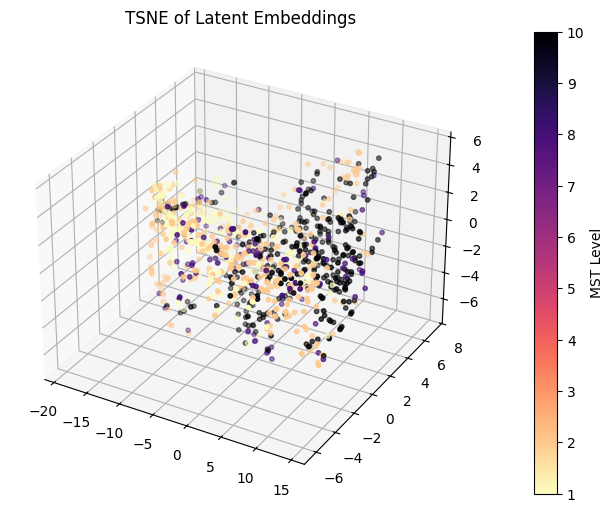

In [8]:
# Helper: map image path → MST level
def get_mst_label(path, dataset):
    subject = os.path.basename(os.path.dirname(path))
    return dataset.subject_to_mst.get(subject, 0)

def visualize_latent_space(model, dataset, method='tsne', save_path=None, device='cpu'):
    model.eval()
    embeddings = []
    labels = []    

    with torch.no_grad():
        for i in range(len(dataset)):
            img = dataset[i][0].unsqueeze(0).to(device)  # dataset[i] returns (image, target)
            mu, _ = model.encode(img)
            embeddings.append(mu.squeeze(0).cpu().numpy())
            labels.append(get_mst_label(dataset.image_paths[i], dataset))

    X = np.stack(embeddings)
    Y = np.array(labels)

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=3, perplexity=30, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=3)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    X_reduced = reducer.fit_transform(X)

    # Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
                         c=Y, cmap='magma_r', s=10)
    ax.set_title(f"{method.upper()} of Latent Embeddings")
    cb = fig.colorbar(scatter, ax=ax, pad=0.1)
    cb.set_label("MST Level")

    if save_path:
        plt.savefig(save_path)
        print(f"Saved latent space plot to {save_path}")
    else:
        plt.show()


model = SkinToneVAE(latent_dim=latent_dim).to(device)
# model.load_state_dict(torch.load("runs/20250412_190402/vae_best.pth", map_location=device))
visualize_latent_space(model, val_dataset, method='tsne', save_path="latent_tsne.png", device=device)

## Latent Space Correlation to LAB-HSL

Saved correlation heatmap to latent_correlation_heatmap_after_regression.png


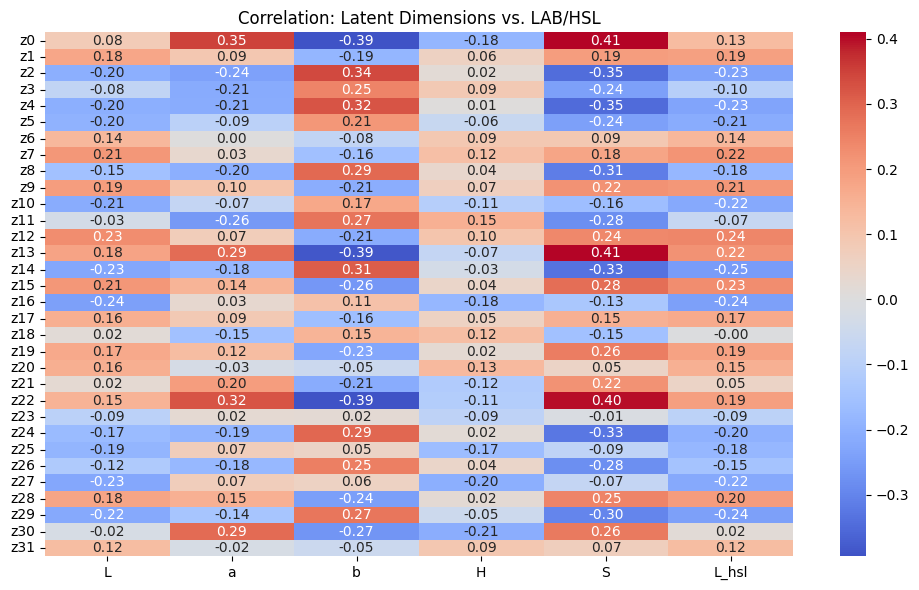

In [9]:
def plot_latent_correlation(model, dataset, device="cpu", save_path=None):
    model.eval()
    zs = []
    targets = []

    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]  # now returns (image, target)
            x = x.unsqueeze(0).to(device)
            mu, _ = model.encode(x)
            zs.append(mu.squeeze(0).cpu().numpy())
            targets.append(y.cpu().numpy())

    Z = pd.DataFrame(zs, columns=[f"z{i}" for i in range(model.latent_dim)])
    T = pd.DataFrame(targets, columns=["L", "a", "b", "H", "S", "L_hsl"])
    corr = pd.concat([Z, T], axis=1).corr().loc[Z.columns, T.columns]

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Correlation: Latent Dimensions vs. LAB/HSL")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved correlation heatmap to {save_path}")
    else:
        plt.show()


plot_latent_correlation(
    model,
    val_dataset,
    device=device,
    save_path="latent_correlation_heatmap_after_regression.png"
)

## Confirm Patches MST

In [10]:
def get_latent_for_mst(model, dataset, target_mst, subject_to_mst, device="cpu"):
    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            path = dataset.image_paths[i]
            subject = os.path.basename(os.path.dirname(path))
            mst = subject_to_mst.get(subject)
            if mst != target_mst:
                continue
            x = dataset[i][0].unsqueeze(0).to(device)
            mu, _ = model.encode(x)
            return mu.squeeze(0).cpu(), i  # <-- also return index
    raise ValueError(f"No sample found for MST {target_mst}")


z_start, idx_start = get_latent_for_mst(model, val_dataset, target_mst=1, subject_to_mst=subject_to_mst, device=device)
z_end, idx_end = get_latent_for_mst(model, val_dataset, target_mst=10, subject_to_mst=subject_to_mst, device=device)

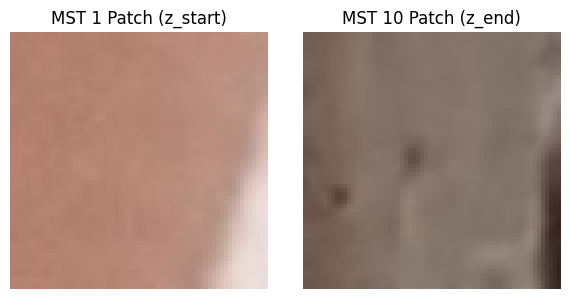

In [11]:
img_start = val_dataset[idx_start][0]
img_end = val_dataset[idx_end][0]

img_start_np = img_start.permute(1, 2, 0).cpu().numpy()
img_end_np = img_end.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_start_np)
plt.title("MST 1 Patch (z_start)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_end_np)
plt.title("MST 10 Patch (z_end)")
plt.axis("off")

plt.tight_layout()
plt.show()

## LAB-HSL across Latent Space

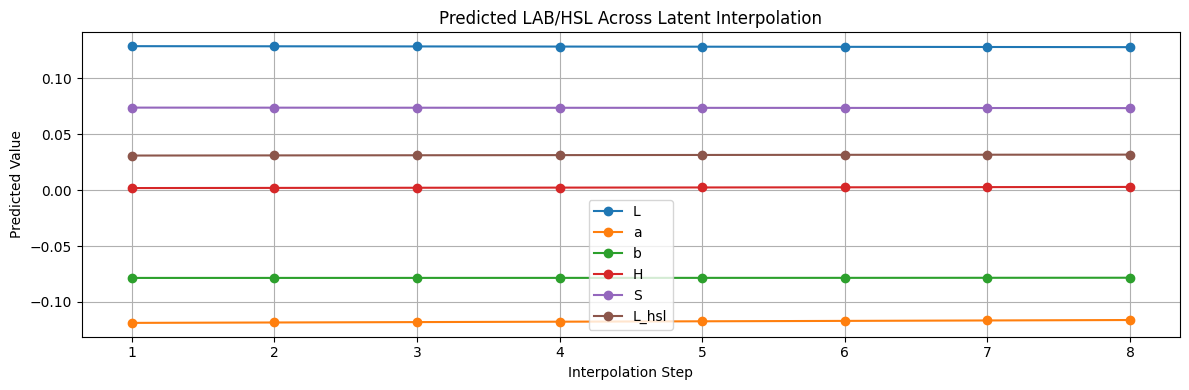

In [13]:
def get_patch_by_mst(dataset, subject_to_mst, target_mst):
    for i, path in enumerate(dataset.image_paths):
        subject = os.path.basename(os.path.dirname(path))
        if subject_to_mst.get(subject) == target_mst:
            return dataset[i][0].unsqueeze(0).to(device)
    return None

def interpolate_and_plot_predictions(model, z_start, z_end, num_steps=8, device="cpu"):
    model.eval()
    z_start = z_start.to(device)
    z_end = z_end.to(device)

    interpolated = torch.stack([
        (1 - alpha) * z_start + alpha * z_end
        for alpha in torch.linspace(0, 1, num_steps)
    ])

    with torch.no_grad():
        predictions = model.color_head(interpolated).cpu().numpy()

    # Convert to a DataFrame for easy plotting
    df = pd.DataFrame(predictions, columns=["L", "a", "b", "H", "S", "L_hsl"])
    df["Step"] = list(range(1, num_steps + 1))

    # Plot each dimension
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(["L", "a", "b", "H", "S", "L_hsl"]):
        plt.plot(df["Step"], df[col], marker='o', label=col)

    plt.title("Predicted LAB/HSL Across Latent Interpolation")
    plt.xlabel("Interpolation Step")
    plt.ylabel("Predicted Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

interpolate_and_plot_predictions(model, z_start, z_end, num_steps=8, device=device)
